In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt
import seaborn as sns

# Load Online Retail dataset
The original dataset can be found here - http://archive.ics.uci.edu/ml/datasets/online+retail

It does have some outliers and missing data, and requires some cleaning. I have created a separate git repo for that, and saves the cleaned file as OnlineClean.xlsx - you can find the notebook, as well as original and cleaned datasets in the repo - https://github.com/karolisurbonas/cleaning-online-retail-dataset

I have also created a smaller version of the file with only `United Kingdom` filtered from the `Country` values, and randomly sampled 20% of the data for faster processing - the file is called `OnlineSampled.xlsx`.

In [2]:
# Pre-processed file
online = pd.read_excel('OnlineClean.xlsx')

## RFM and Clustering Segmentation goals

We will build summary datasets on a `CustomerID` level for the RFM and Clustering analyses. We will calculate these values:

1. Tier 1 metrics for RFM segmentation:
 - **Recency** - Days since last transaction
 - **Frequency** - Total number of transactions
 - **MonetaryValue** - Total sum of money spent with the company
 - **Tenure** - days since first transaction


2. Tier 2 metrics for more advanced segmentation (clustering):
 - **Frequency Monthly** - Average number of transactions monthly
 - **QuantityTotal** - Total number of items bought with the company (sum of `Quantity`)
 - **QuantityMonthly** - Average number of items bought monthly
 - **PriceAverage** - Average Unit Price of each purchase
 - **MonetaryValueMonthly** - Average sum of money spent with the company monthly
 - **MonthsActive** - Number of months when customer shopped at the store
 - **DaysActive** - Count of active days
 - **AverageDaysActiveMonthly** - Average days active in a month since first transaction
 - **DaysActiveShare** - Share of active days of total tenure in days

Then we will rund the RFM segmentation on the tier 1 metrics, and discuss potential uses of it. 

In the last section we will use both tier 1 and tier 2 metrics to run cluster analysis to uncover behavioral segments, and see if adding more features (tier 2 metrics) can get us to a more interpretable segmentation solution.

In [3]:
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


# 1. Data preparation for RFM segmentation

### Convert InvoiceDate from datetime object to a date

Let's remove the time from the `InvoiceDate` and leave it as a date only.

In [4]:
online['InvoiceDate'] = online['InvoiceDate'].dt.date

### Further data cleaning

Typically for RFM analysis we need 1 year's worth of data, so let's restrict our dataset to have 12 months of data only.

In [5]:
print('Min date = {}, Max date = {}'.format(min(online.InvoiceDate), max(online.InvoiceDate)))

Min date = 2010-12-01, Max date = 2011-12-09


In [6]:
online = online[online['InvoiceDate']>dt.date(2010,12,9)]

Now, let's create a monthly date so we can aggregate monthly metrics later

In [7]:
online['InvoiceMonth'] = online['InvoiceDate'].apply(lambda x: dt.date(x.year, x.month, 1))

In [8]:
online[-5:]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09,0.85,12680,France,2011-12-01
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09,2.10,12680,France,2011-12-01
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09,4.15,12680,France,2011-12-01
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09,4.15,12680,France,2011-12-01
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09,4.95,12680,France,2011-12-01


### Create snapshot date

In the real world, we would typically be able to access such data daily with the most recent transactions present. Since this dataset is historical and we can't update it with the most recent numbers, we have to assume that the time when it was pulled was +1 day after the last transaction was recorded. 

First, let's check the smallest and largest `InvoiceDate` values, and then we can create a new variable `snapshot_date` which we will use for the RFM calculations.

In [9]:
print('Min date = {}, Max date = {}'.format(min(online.InvoiceDate), max(online.InvoiceDate)))

Min date = 2010-12-10, Max date = 2011-12-09


In [10]:
snapshot_date = max(online.InvoiceDate) + dt.timedelta(days=1)

### Calculate purchase value

Let's calculate the basket value by multiplying `Quantity` and `UnitPrice` and storing this into `TotalSum` variable.

In [11]:
online['TotalSum'] = online['Quantity'] * online['UnitPrice']

# 2. Create segmentation datamart

In this section we will create a new DataFrame called `datamart` which will store values at a `CustomerID` level for further RFM and clustering analyses.

## 2.1. Add Tier 1 metrics

First, we will calculate tier 1 metrics. Let's first add three main metrics: Recency (R), Frequency (F), and Monetary Value (M)

In [12]:
datamart = online.groupby(['CustomerID']).agg({
    'InvoiceMonth': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'
}).sort_index(ascending=True)

Next, we need to rename the columns so they are easier to interpret.

In [13]:
datamart.rename(columns = {'InvoiceMonth': 'Recency',
                           'InvoiceNo': 'Frequency',
                           'TotalSum': 'MonetaryValue'}, inplace=True)

Finally, let's add `Tenure` variable.

In [14]:
datamart['Tenure'] = online.groupby(['CustomerID']).agg({
    'InvoiceMonth': lambda x: (snapshot_date - x.min()).days}).sort_index(ascending=True)

In [15]:
datamart[:5]

,Recency,Frequency,MonetaryValue,Tenure
CustomerID,,,,
12346,343,1,77183.60,343
12347,9,151,3598.21,343
12348,100,31,1797.24,374
12349,39,73,1757.55,39
12350,312,17,334.40,312


## 2.2. Add Tier 2 metrics

In this section we will calculate each metric with a separate code line for easier interpretation.

In [16]:
datamart['FrequencyMonthly'] = (online.groupby(['CustomerID', 'InvoiceMonth'])['InvoiceNo'].agg('count').
                                groupby(['CustomerID']).mean().sort_index(ascending=True))

datamart['QuantityTotal'] = (online.groupby(['CustomerID'])['Quantity'].agg('sum').sort_index(ascending=True))

datamart['PriceAverage'] = (online.groupby(['CustomerID'])['UnitPrice'].mean().sort_index(ascending=True))

datamart['MonetaryValueMonthly'] = (online.groupby(['CustomerID', 'InvoiceMonth'])['TotalSum'].agg('sum').
                                groupby(['CustomerID']).mean().sort_index(ascending=True))

datamart['MonthsActive'] = (online.groupby(['CustomerID'])['InvoiceMonth'].nunique().sort_index(ascending=True))

datamart['DaysActive'] = (online.groupby(['CustomerID'])['InvoiceDate'].nunique().sort_index(ascending=True))

datamart['AverageDaysActiveMonthly'] = datamart['DaysActive'] / datamart['MonthsActive']

datamart['DaysActiveShare'] = datamart['DaysActive'] / datamart['Tenure']

In [17]:
datamart[30:40]

,Recency,Frequency,MonetaryValue,Tenure,FrequencyMonthly,QuantityTotal,PriceAverage,MonetaryValueMonthly,MonthsActive,DaysActive,AverageDaysActiveMonthly,DaysActiveShare
CustomerID,,,,,,,,,,,,
12381,9,87,1845.31,131,21.750000,808,4.683218,461.327500,4,5,1.250000,0.038168
12383,192,99,1850.56,374,19.800000,1532,3.086970,370.112000,5,5,1.000000,0.013369
12384,39,27,585.27,131,13.500000,126,7.879259,292.635000,2,2,1.000000,0.015267
12386,343,2,143.00,343,2.000000,140,1.050000,143.000000,1,1,1.000000,0.002915
12388,39,100,2780.66,343,16.666667,1462,2.777700,463.443333,6,6,1.000000,0.017493
12390,100,32,549.84,100,32.000000,353,3.996875,549.840000,1,1,1.000000,0.010000
12391,39,100,460.89,39,100.000000,300,2.459900,460.890000,1,1,1.000000,0.025641
12393,100,64,1582.60,343,21.333333,816,2.279688,527.533333,3,4,1.333333,0.011662
12394,70,27,1272.48,223,13.500000,819,3.370741,636.240000,2,2,1.000000,0.008969


### Correlation heatmap

Let's check it out if any of our features are correlated. We are going to use `.corr()` method on the `datamart` we have just created, and then plot it as a heatmap using `seaborn` library.

Good link for seaborn color palettes - https://chrisalbon.com/python/data_visualization/seaborn_color_palettes/

In [18]:
correlation_m = datamart.corr().round(2)

**Before plotting heatmap**, we might want to remove the information in the correlation matrix as half of it is redundant i.e. lower triangle and upper triangle of the matrix are the same, except for the diagonal which is the correlation for each variable of itself, and always accounts to 100%.

We will do that by using `numpy` function `tril_indices` which calculates **[l]**ower **[tri]**angle indices. Then we will create a `mask` variable that we will pass to the `heatmap` function call.

You can read more about the `tril_indices` function [here](https://docs.scipy.org/doc/numpy/reference/generated/numpy.triu_indices.html). There are also functions like `triu_indices` for the **u**pper **tri**angle indices, or functions `tril` and `triu` that return zeros for either lower or upper part of the triangle matrix.

In [19]:
il = np.tril_indices(12, -1)
mask = np.zeros_like(correlation_m)
mask[il] = True

#### Correlation insights

There are some interesting findings from the correlation heatmap:
- Recency is negatively correlated with frequency and monetary value since these customers had less time to be active
- Interestingly, price is mostly uncorrelated with other values
- Monetary Value is mostly correlated to total quantity (93%), and very little with the price

While there could be some considerations on whether some of the metrics could be removed, it's beyond the scope of this notebook.

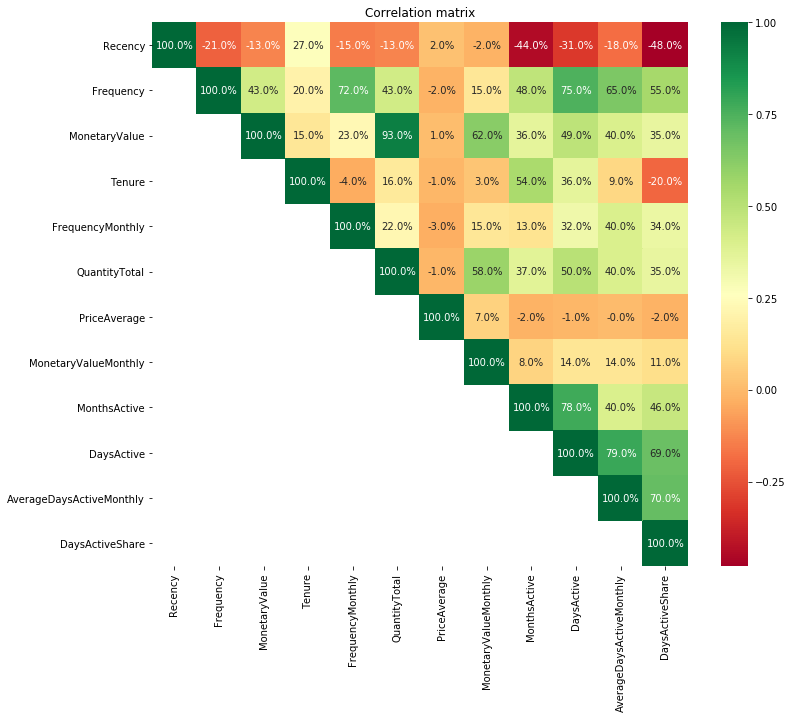

In [21]:
plt.figure(figsize=(12, 10))
plt.title('Correlation matrix')
sns.heatmap(correlation_m, annot=correlation_m, cmap='RdYlGn', fmt='.1%', mask=mask)
plt.show()

# 3. Create RFM table and analyze RFM segments

We will first create three columns `R`, `F`, and `M` that will be the RFM scores. There are multiple ways to assign these values:
 1. Based on quartile (or other percentile) values
 2. Pareto (80/20)
 3. Custom - based on business or market knowledge

In this section, we will implement quartile (**No. 1**) approach.

In [22]:
Rquartiles = pd.qcut(datamart['Recency'], 4, labels = range(1,5))
datamart = datamart.assign(R = Rquartiles.values)

In [23]:
datamart[:5]

,Recency,Frequency,MonetaryValue,Tenure,FrequencyMonthly,QuantityTotal,PriceAverage,MonetaryValueMonthly,MonthsActive,DaysActive,AverageDaysActiveMonthly,DaysActiveShare,R
CustomerID,,,,,,,,,,,,,
12346,343,1,77183.60,343,1.000000,74215,1.040000,77183.600000,1,1,1.0,0.002915,4
12347,9,151,3598.21,343,25.166667,2139,2.593510,599.701667,6,6,1.0,0.017493,1
12348,100,31,1797.24,374,7.750000,2341,5.764839,449.310000,4,4,1.0,0.010695,3
12349,39,73,1757.55,39,73.000000,631,8.289041,1757.550000,1,1,1.0,0.025641,1
12350,312,17,334.40,312,17.000000,197,3.841176,334.400000,1,1,1.0,0.003205,4


Now let's assign `F`, `M`, and `T` (for **T**enure) values based on quartiles.

For `Frequency`, `MonetaryValue` and `Tenure` we will have to reverse the labels because in this case the larger the value, the better, while with `Recency` we want these values

In [24]:
Fquartiles = pd.qcut(datamart['Frequency'], 4, labels = list(reversed(range(1,5))))
datamart = datamart.assign(F = Fquartiles.values)

Mquartiles = pd.qcut(datamart['MonetaryValue'], 4, labels = list(reversed(range(1,5))))
datamart = datamart.assign(M = Mquartiles.values)

Tquartiles = pd.qcut(datamart['Tenure'], 4, labels = list(reversed(range(1,5))))
datamart = datamart.assign(T = Tquartiles.values)

In [25]:
datamart[:5]

,Recency,Frequency,MonetaryValue,Tenure,FrequencyMonthly,QuantityTotal,PriceAverage,MonetaryValueMonthly,MonthsActive,DaysActive,AverageDaysActiveMonthly,DaysActiveShare,R,F,M,T
CustomerID,,,,,,,,,,,,,,,,
12346,343,1,77183.60,343,1.000000,74215,1.040000,77183.600000,1,1,1.0,0.002915,4,4,1,1
12347,9,151,3598.21,343,25.166667,2139,2.593510,599.701667,6,6,1.0,0.017493,1,1,1,1
12348,100,31,1797.24,374,7.750000,2341,5.764839,449.310000,4,4,1.0,0.010695,3,3,1,1
12349,39,73,1757.55,39,73.000000,631,8.289041,1757.550000,1,1,1.0,0.025641,1,2,1,4
12350,312,17,334.40,312,17.000000,197,3.841176,334.400000,1,1,1.0,0.003205,4,4,3,2


In [26]:
datamart['RFMScore'] = datamart[['R','F','M']].apply(lambda x: ''.join(x.map(str)), axis=1)

In [27]:
rfm_index = ['Recency', 'Frequency', 'MonetaryValue', 'RFMScore']
datamart[datamart['RFMScore']=='111'][rfm_index].sort_values('MonetaryValue', ascending=False)[:10]

,Recency,Frequency,MonetaryValue,RFMScore
CustomerID,,,,
14646,9,2076,280206.02,111
18102,9,413,231822.69,111
17450,9,334,192521.95,111
14911,9,5514,139413.48,111
12415,39,714,124914.53,111
14156,39,1397,117057.43,111
17511,9,920,87591.70,111
16029,39,230,76753.32,111
16684,9,277,66653.56,111


In [28]:
datamart[rfm_index].sort_values('RFMScore', ascending=False)[:10]

,Recency,Frequency,MonetaryValue,RFMScore
CustomerID,,,,
15894,284,3,106.81,444
13284,343,13,201.19,444
13295,374,10,201.20,444
16055,223,8,134.80,444
16050,192,10,137.90,444
16647,192,14,214.06,444
16659,192,2,39.12,444
13299,284,5,142.50,444
17789,284,14,225.90,444


In [29]:
datamart[rfm_index].sort_values('MonetaryValue', ascending=False)[:10]

,Recency,Frequency,MonetaryValue,RFMScore
CustomerID,,,,
14646,9,2076,280206.02,111
18102,9,413,231822.69,111
17450,9,334,192521.95,111
16446,9,3,168472.50,141
14911,9,5514,139413.48,111
12415,39,714,124914.53,111
14156,39,1397,117057.43,111
17511,9,920,87591.70,111
12346,343,1,77183.60,441


# 4. Customer segmentation by clustering

In this section we will use `Recency`, `Frequency`, and `MonetaryValue` variables to segment the customers into homogenous groups using K-means clustering algorithm. 

Later, we will explore how adding additional variables like `Tenure` and others impacts the segmentation solution.

Then, we will run a clustering exercise on the full dataset, and see if the additional features give us more interpretable segments.

Finally, we will review other techniques like [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), [Gaussian Mixture Models](http://scikit-learn.org/stable/modules/mixture.html) and [NMF](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html) to show how they can be used in extracting insights into the data and build segmentation projects.

## 4.1. Clustering with k-means on tier 1 metrics

In [30]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [31]:
# Filter out 3 key metrics for the first iteration
rfm_index = ['Recency', 'Frequency', 'MonetaryValue']
datamart_rfm = datamart[rfm_index]

### Pre-process data for Kmeans

KMeans algorithm works best with normally-distributed and standardized data, so we will first run a log transformation to reduce the skew and compress the heavy tails. Then, we will scale and center the data, so the mean and variance are the standardized.

More information about data preparation for KMeans - https://stats.stackexchange.com/questions/325676/should-k-means-only-be-applied-if-the-variables-are-normally-distributed

In [32]:
# Transform inputs to a log scale
datamart_rfm = np.log(datamart_rfm)

In [33]:
# Standardize the data by centering and scaling
scaler = StandardScaler()
scaler.fit(datamart_rfm)
data_3rfm = scaler.transform(datamart_rfm)

### Evaluate the number of clusters using Elbow Method

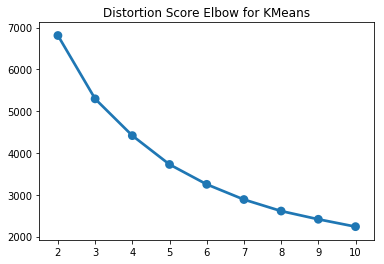

In [34]:
sse = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=99).fit(data_3rfm)
    cluster_labels = kmeans.labels_
    sse[k] = kmeans.inertia_
    # Inertia = Sum of squared distances of samples to their closest cluster center.

plt.title('Distortion Score Elbow for KMeans')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

### Evaluate the number of clusters using Silhouette Score

Documentation here - http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

Ultimately, we will make the call about the right number of clusters based on the interpretability of the segmentation solution. This method, along with the elbow method described above, gives us guidance of what is the range of the number of clusters we should explore.

As you can see in the thread in stackoverflow [here](https://stackoverflow.com/questions/19197715/scikit-learn-k-means-elbow-criterion), the Silhouette score is highest for the 2-cluster solution, alhtough the underlying dataset has three distint classes with visible decision boundaries, so we should always take these scores as directional insights that will guide us towards the best\* solution. 

*
**Best** solution will be the one that makes most business sense and enables the managers to act upon the insights provided by the segmentation.*

In [35]:
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=99).fit(data_3rfm)
    cluster_labels = kmeans.labels_
    sil_score = silhouette_score(data_3rfm, cluster_labels, metric='euclidean')
    print("K: {}, Silhouette Score: {}".format(k, sil_score))

K: 2, Silhouette Score: 0.39009018897164704
K: 3, Silhouette Score: 0.29870018382890084
K: 4, Silhouette Score: 0.30154503824823303
K: 5, Silhouette Score: 0.304306607826188
K: 6, Silhouette Score: 0.30573749553402746
K: 7, Silhouette Score: 0.2998899413337688
K: 8, Silhouette Score: 0.29972071305191644
K: 9, Silhouette Score: 0.29288178993411734
K: 10, Silhouette Score: 0.297452409336366


### Fancy visualizations for Elbow Method and Silhouette Score

[**Yellowbrik**](http://www.scikit-yb.org/en/latest/index.html) is an extension to Scikit Learn API with a series of visualization tools. You will have to install it (`pip install yellowbrik` did the job to me) before you can use it. You can import the functions with the following commands.

`from yellowbrick.cluster import KElbowVisualizer`

`from yellowbrick.cluster import SilhouetteVisualizer`

I personally prefer using the simple calculations like above from the main `sklearn` API, so I will leave this library for users of the notebook to test out.

### Running Kmeans clustering and comparing results for different K

Now we will review the metrics - `Recency`, `Frequency` and `Monetary Value` - for each cluster based on different segmentation solutions i.e. varying K values. 

We will be looking to find interpretable segments that make sense from business perspective. This is a critical moment where feedback from the business teams is very important, as we want to merge industry knowledge with the story that the segmentation speaks. 

### 2-cluster solution



In [36]:
kmeans = KMeans(n_clusters=2, random_state=99).fit(data_3rfm)
cluster_labels = kmeans.labels_
datamart.assign(cluster = cluster_labels).groupby(['cluster']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count'],
}).round(0)

Recency Frequency MonetaryValue      
           mean      mean          mean count
cluster                                      
0          45.0     169.0        3878.0  1943
1         151.0      24.0         459.0  2321

### 3-cluster solution

In [37]:
kmeans = KMeans(n_clusters=3, random_state=99).fit(data_3rfm)
cluster_labels = kmeans.labels_
datamart.assign(cluster = cluster_labels).groupby(['cluster']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count'],
}).round(0)

Recency Frequency MonetaryValue      
           mean      mean          mean count
cluster                                      
0         183.0      14.0         283.0  1416
1          28.0     249.0        6098.0  1025
2          82.0      59.0        1068.0  1823

### 4-cluster solution

In [38]:
kmeans = KMeans(n_clusters=4, random_state=99).fit(data_3rfm)
cluster_labels = kmeans.labels_
datamart.assign(cluster = cluster_labels).groupby(['cluster']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count'],
}).round(0)

Recency Frequency MonetaryValue      
           mean      mean          mean count
cluster                                      
0          89.0      84.0        1522.0  1467
1          44.0      25.0         394.0   855
2          21.0     283.0        7253.0   782
3         217.0      16.0         309.0  1160

### 5-cluster solution

In [39]:
kmeans = KMeans(n_clusters=5, random_state=99).fit(data_3rfm)
cluster_labels = kmeans.labels_
datamart.assign(cluster = cluster_labels).groupby(['cluster']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count'],
}).round(0)

Recency Frequency MonetaryValue      
           mean      mean          mean count
cluster                                      
0         182.0       7.0         194.0   693
1          45.0      35.0         535.0  1006
2         196.0      35.0         684.0   991
3          61.0     154.0        2906.0  1091
4           9.0     289.0        8444.0   483

### 6-cluster solution

In [40]:
kmeans = KMeans(n_clusters=6, random_state=99).fit(data_3rfm)
cluster_labels = kmeans.labels_
datamart.assign(cluster = cluster_labels).groupby(['cluster']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count'],
}).round(0)

Recency Frequency MonetaryValue      
           mean      mean          mean count
cluster                                      
0         188.0       6.0         184.0   573
1          22.0     406.0       11383.0   430
2          60.0      29.0         476.0   994
3          68.0     109.0        1928.0  1144
4           9.0      75.0        1259.0   348
5         230.0      32.0         621.0   775

### 7-cluster solution

In [41]:
kmeans = KMeans(n_clusters=7, random_state=99).fit(data_3rfm)
cluster_labels = kmeans.labels_
datamart.assign(cluster = cluster_labels).groupby(['cluster']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count'],
}).round(0)

Recency Frequency MonetaryValue      
           mean      mean          mean count
cluster                                      
0          61.0      59.0         904.0   967
1          12.0     464.0       14436.0   280
2         226.0       7.0         187.0   487
3          57.0      16.0         308.0   621
4          63.0     174.0        3277.0   741
5           9.0      80.0        1311.0   336
6         215.0      33.0         640.0   832

# Further considerations on clustering with NMF

In the past I have used non-negative matrix factorization for segmentation as it simultaneously groups rows **and** columns. There's a great blog [Engaging Market Research](http://joelcadwell.blogspot.com/) by Joel Cadwell where he presents multiple examples of how customers can be segmented using NMF as well as other methods like Archetypal analysis. The only caveat is that he uses `R` language, but the posts are very enjoyable and informative.

Links to Python's NMF documentation:
- http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
- https://stackoverflow.com/questions/29648955/sklearn-matrix-factorization-example